In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import spdiags, csr_matrix
from scipy.sparse.linalg import gmres, bicgstab
from scipy.integrate import solve_ivp
from scipy.fftpack import fft2, ifft2
from scipy.linalg import lu, solve_triangular

In [7]:
# Building matrices from Homework 4

# Building A matrix
m = 64
n = m * m
x2 = np.linspace(-10, 10, m+1)
dx = x2[1] - x2[0]


e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0  # overwrite every m^th value with zero
    e4[m*j-1] = 1  # overwirte every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Place diagonal elements
diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

matA = spdiags(diagonals, offsets, n, n).toarray()
A = (dx)**(-2) * matA

# Building B matrix
diagonals = [e1.flatten(), -e1.flatten(), e1.flatten(), -e1.flatten()]
offsets = [-(n-m), -m, m, (n-m)]
matB = spdiags(diagonals, offsets, n ,n).toarray()
B = (2 * dx)**(-1) * matB

# Building C matrix
diagonals = [e5.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets = [-m+1, -1, 1, m-1]
matC = spdiags(diagonals, offsets, n, n).toarray()
C = (2 * dx)**(-1) * matC

In [8]:
# Part (a)

# Define parameters
tspan = np.arange(0, 4.5, 0.5) # Ask about this
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(-X**2 - 0.05 * Y**2)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Define function for RHS of vorticity equation
def vorticity_rhs_fft(w, t, A, B, C, nx, ny, K, nu):
    # Solving for streamfunction with FFT
    
    ## Take FFT of w
    wt = fft2(w.reshape((nx,ny), order = 'F'))

    ## Solve for Fourier Transform of psi from stream function
    psit = -wt / K

    ## Get inverse Fourier Transform of psi to use in vorticity
    psi = np.real(ifft2(psit)).reshape(N, order = 'F')

    # Solving for vorticity function
    ## Calculating derivatives using A, B, C matrices above
    wx = np.dot(B, w)
    wy = np.dot(C, w)
    psix = np.dot(B, psi)
    psiy = np.dot(C, psi)
    w_laplace = np.dot(A, w)

    ## RHS of vorticity 
    rhs = psiy * wx - psix * wy + nu * w_laplace

    return rhs

In [15]:
# Solve for vorticity using solve_ivp

start_time = time.time()

w0 = np.exp(-X**2 - 0.05 * Y**2).reshape(N, order = 'F')
sol = solve_ivp(lambda t, w: vorticity_rhs_fft(w, t, A, B, C, nx, ny, K, nu),
                t_span = [0, 4], y0 = w0, t_eval = tspan)
wsol = sol.y.T

end_time = time.time()

elapsed_time_fft = end_time - start_time

print(f'{elapsed_time_fft} seconds for FFT')

0.5717597007751465 seconds for FFT


/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_96759/3578195898.py:7: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


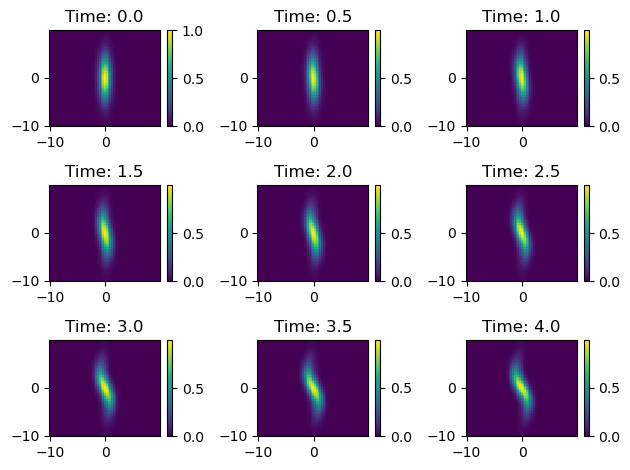

In [10]:
# Save and plot results
A1 = np.zeros((9,64,64))
for j, t in enumerate(tspan):
    w = wsol[j].reshape((nx, ny), order = 'F')
    A1[j] = w
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

31.416499137878418 seconds for solve(A,b)


/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_96759/2953641802.py:56: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


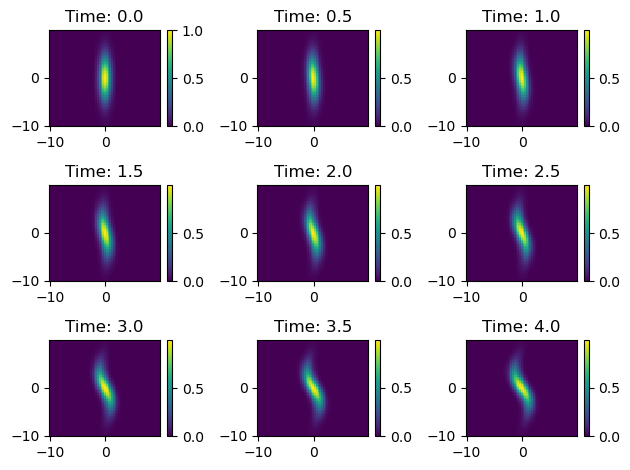

In [16]:
# Part (b)


# Using solve(A,b)
A[0,0] = 2


# Save initial condition as 1D array
w0 = np.exp(-X**2 - 0.05 * Y**2).reshape(N, order = 'F')

# Function that calculates RHS of vorticity equation with finite differences
def vorticity_rhs_fd(w, t, nu, A, B, C, nx, ny):

    # Solving for streamline function
    psi = np.linalg.solve(A, w)

    # Converting A, B, C to csr_matrix format for faster computation

    A_sparse = csr_matrix(A)
    B_sparse = csr_matrix(B)
    C_sparse = csr_matrix(C)

    # Calculating derivatives using A, B, C matrices above
    wx = B_sparse.dot(w)
    wy = C_sparse.dot(w)
    psix = B_sparse.dot(psi)
    psiy = C_sparse.dot(psi)
    w_laplace = A_sparse.dot(w)
    
    # RHS of vorticity 
    rhs = psiy * wx - psix * wy + nu * w_laplace
  
    # Reshape into 1D array
    return rhs

# Solve vorticity equation with solve_ivp

start_time = time.time()

sol = solve_ivp(lambda t, w: vorticity_rhs_fd(w, t, nu, A, B, C, nx, ny),
                t_span = [0, 4], y0 = w0, t_eval = tspan)
wsol = sol.y.T

end_time = time.time()

elapsed_time_solve = end_time - start_time

print(f'{elapsed_time_solve} seconds for solve(A,b)')

# Save and plot results 
A2 = np.zeros((9,64,64))
for j, t in enumerate(tspan):
    w = wsol[j].reshape((nx, ny), order = 'F')
    A2[j] = w
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()



10.76474905014038 seconds for LU-decomposition


/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_96759/763954113.py:51: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


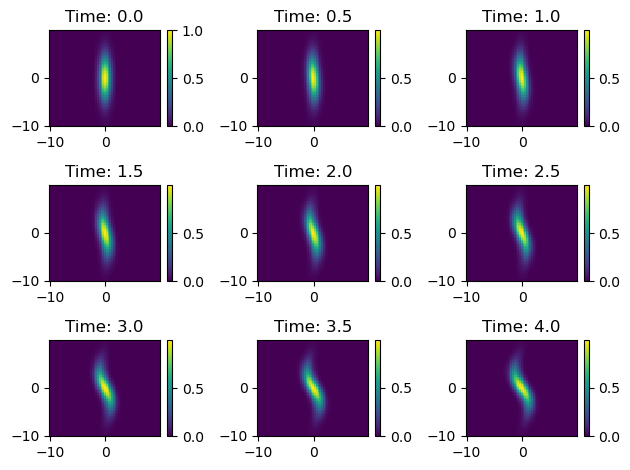

In [17]:
# Using LU-Decomposition
w0 = np.exp(-X**2 - 0.05 * Y**2).reshape(N, order = 'F')

P, L, U = lu(A)

# Function that calculates RHS of vorticity equation with LU-decomposition
def vorticity_rhs_lu(w, t, nu, P, L, U, A, B, C, nx, ny):

    # Solving for streamline function using LU-decomposition
    Pw = np.dot(P, w)
    y = solve_triangular(L, Pw, lower = True)
    psi = solve_triangular(U, y)

    # Converting A, B, C to csr_matrix format for faster computation

    A_sparse = csr_matrix(A)
    B_sparse = csr_matrix(B)
    C_sparse = csr_matrix(C)

    # Calculating derivatives using A, B, C matrices above
    wx = B_sparse.dot(w)
    wy = C_sparse.dot(w)
    psix = B_sparse.dot(psi)
    psiy = C_sparse.dot(psi)
    w_laplace = A_sparse.dot(w)
    
    # RHS of vorticity 
    rhs = psiy * wx - psix * wy + nu * w_laplace
  
    # Reshape into 1D array
    return rhs

# Solve vorticity equation with solve_ivp

start_time = time.time()
sol = solve_ivp(lambda t, w: vorticity_rhs_lu(w, t, nu, P, L, U, A, B, C, nx, ny),
                t_span = [0, 4], y0 = w0, t_eval = tspan)
wsol = sol.y.T
end_time = time.time()

elapsed_time_lu = end_time - start_time

print(f'{elapsed_time_lu} seconds for LU-decomposition')

# Save and plot results 
A3 = np.zeros((9,64,64))
for j, t in enumerate(tspan):
    w = wsol[j].reshape((nx, ny), order = 'F')
    A3[j] = w
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()